In [1]:
import sys
sys.path.insert(0, "./src/")

# 00-Sanity-checks

Run sanity checks for attacks and data modification.

In [2]:
import tqdm
import os

import torch
import torchvision
import torch.nn as nn
import matplotlib.pyplot as plt

from src.utils.data_utils import get_cifar10_data
from src.utils.adversary_utils import adv_attack
from src.utils.vis_utils import vis_pred

In [3]:
data = get_cifar10_data(1, img_size=32, subsample=True)
classes = data["classes"]
_, test_loader = data["test"]

Files already downloaded and verified
Files already downloaded and verified


In [4]:
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, len(classes))
model.load_state_dict(torch.load(os.path.join(r"ckpts\standard_d_v7\best.pt")))
model.to("cuda");
model.eval();

## 1. Closer look at attack

True label:  horse
Prediced label on original image:  cat
Prediction after adv attack 1:  frog


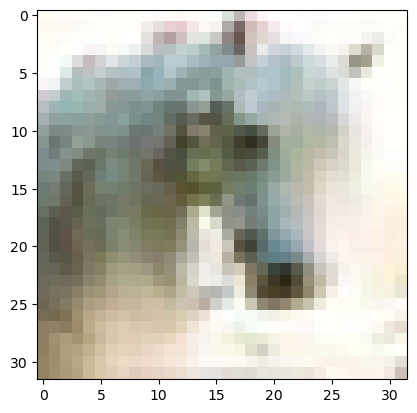

In [13]:
for batch in test_loader:
    pred = model(batch[0].to("cuda")).argmax(1)
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=10, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediced label on original image: ", classes[pred])
    print("Prediction after adv attack 1: ", classes[adv])
    break

True label:  frog
Prediced label on original image:  frog
Prediction after adv attack 1:  dog


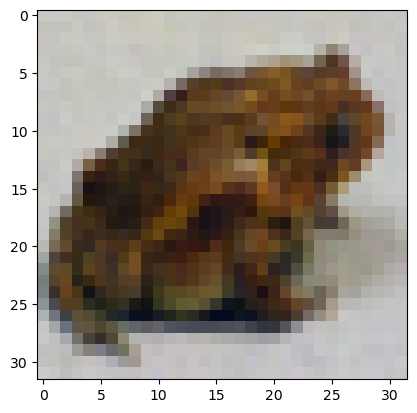

In [16]:
for batch in test_loader:
    pred = model(batch[0].to("cuda")).argmax(1)
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=10, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediced label on original image: ", classes[pred])
    print("Prediction after adv attack 1: ", classes[adv])
    break

True label:  deer
Prediced label on original image:  deer
Prediction after adv attack 1:  dog


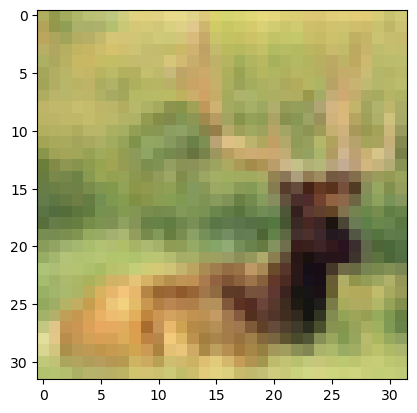

In [15]:
for batch in test_loader:
    pred = model(batch[0].to("cuda")).argmax(1)
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=10, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediced label on original image: ", classes[pred])
    print("Prediction after adv attack 1: ", classes[adv])
    break

True label:  dog
Prediction after adv attack 1:  cat


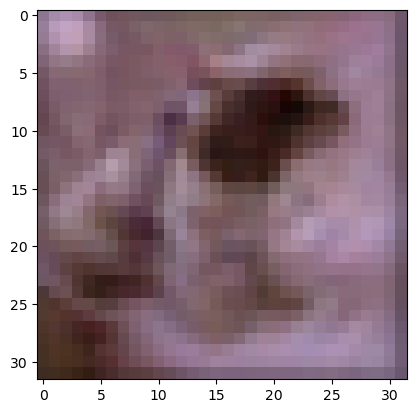

In [19]:
for batch in test_loader:
    res = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=1, steps=20, alpha=0.1)
    true_y = batch[1]
    adv = model(res[0].to("cuda")).argmax(1)
    img_whc = res[0].squeeze().numpy().transpose(1,2,0)
    plt.imshow(img_whc)
    print("True label: ", classes[true_y])
    print("Prediction after adv attack 1: ", classes[adv])
    break

## 2. Compare prediction of model before and after attack

In [17]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=0.5, steps=7, alpha=0.1)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [07:53<00:00,  5.28it/s]

tensor([[ 374., 1675.],
        [   0.,  451.]])


In [19]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), epsilon=1, steps=20, alpha=0.1)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [19:55<00:00,  2.09it/s]

tensor([[  16., 2033.],
        [   0.,  451.]])


Check whether targeted attacks behave like untargeted ones.

In [13]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), target=(batch[1]+1) % 10, epsilon=0.5, steps=7, alpha=0.1)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

  0%|          | 0/2500 [00:00<?, ?it/s]

100%|██████████| 2500/2500 [08:48<00:00,  4.73it/s]

tensor([[ 967., 1082.],
        [  23.,  428.]])


In [14]:
# [[cor_bef_cor_after, cor_before_wrong_after],
#  [wrong_before_cor_after, wrong_before_wrong_after]]
conf_ma = torch.zeros((2,2)) 
for batch in tqdm.tqdm(test_loader):
    x, y = batch[0], batch[1].item()
    pred = model(x.to("cuda")).argmax(1).item()
    adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), target=(batch[1]+1) % 10, epsilon=2, steps=7, alpha=0.1)
    pred_adv = model(adv_batch[0].to("cuda")).argmax(1).item()
    if (y==pred) and (y==pred_adv):
        conf_ma[0,0] +=1
    elif (y==pred) and (y!=pred_adv):
        conf_ma[0,1] +=1
    elif (y!=pred) and (y==pred_adv):
        conf_ma[1, 0] += 1
    else:
        conf_ma[1, 1] += 1
    
print(conf_ma)

100%|██████████| 2500/2500 [08:48<00:00,  4.73it/s]

tensor([[ 618., 1431.],
        [  17.,  434.]])


## 3. Make sure pertubations only are in epsilon norm range

In [15]:
BS = 64
data = get_cifar10_data(BS, img_size=32, subsample=True)
classes = data["classes"]
_, test_loader = data["test"]

Files already downloaded and verified
Files already downloaded and verified


In [16]:
for eps in tqdm.tqdm([0.5, 1, 5]):
    for batch in tqdm.tqdm(test_loader):
        x = batch[0]
        if x.shape[0] == BS: # skip last incomplete batch
            adv_batch = adv_attack(batch, model, nn.CrossEntropyLoss(), target=torch.randint(low=0, high=5, size=(64,)).type(torch.LongTensor) , epsilon=eps, steps=7, alpha=0.1)
            assert(torch.all((x-adv_batch[0]).reshape(x.shape[0],-1).norm(p=2, dim=-1) <= eps + 1e-6))
print("All modifications are within maximum allowed norm.")

 67%|██████▋   | 2/3 [00:20<00:10, 10.46s/it]